In [1]:
import sys
import IPython.display
import numpy
import matplotlib.pyplot
import matplotlib.collections
import fzreader

In [2]:
def plot_camera(data, ax=None):
    x,y,r = numpy.hsplit(numpy.loadtxt('wc490.txt'),3)
    scale = max(data)

    if(ax is None):
        fig, ax = matplotlib.pyplot.subplots(dpi=150)

    edge_patches = []
    face_patches = []
    for i in range(490):
        edge_patches.append(matplotlib.pyplot.Circle((x[i],y[i]), r[i]))
        face_patches.append(matplotlib.pyplot.Circle((x[i],y[i]), r[i]*max(data[i],0)/scale))
    
    patch_collection = matplotlib.collections.PatchCollection(face_patches)
    patch_collection.set_facecolor('b')
    patch_collection.set_linewidth(0)
    ax.add_collection(patch_collection)

    patch_collection = matplotlib.collections.PatchCollection(edge_patches, alpha=0.4)
    patch_collection.set_edgecolor('k')
    patch_collection.set_facecolor('none')
    patch_collection.set_linewidth(0.5)
    ax.add_collection(patch_collection)

    ax.set_xlim([-2.05,2.05])
    ax.set_ylim([-2.05,2.05])
    ax.set_box_aspect(1)

    return ax

# Calculate pedestals

Loop through all records in the FZ file and extract those with `record_type==event` and `event_type==pedestal`. Count all such events in `nped` and sum the charges from the 490 ADCs in `ped_sum` and the square if the charges in `ped_sum_sq`.

We can then calculate the pedestal value and its RMS.

In [3]:
nped = 0
ped_sum = numpy.zeros(492)
ped_sum_sq = numpy.zeros(492)
with fzreader.FZReader('gt014862.fz',verbose=False) as fz:
    for record in fz:
        if(record['record_type'] == 'event' and record['event_type'] == 'pedestal'):
            nped += 1
            adc_values = numpy.asarray(record['adc_values'], dtype=float)
            ped_sum += adc_values
            ped_sum_sq += adc_values ** 2

In [4]:
ped_val = ped_sum/nped
ped_rms = numpy.sqrt(ped_sum_sq/nped - ped_val**2)

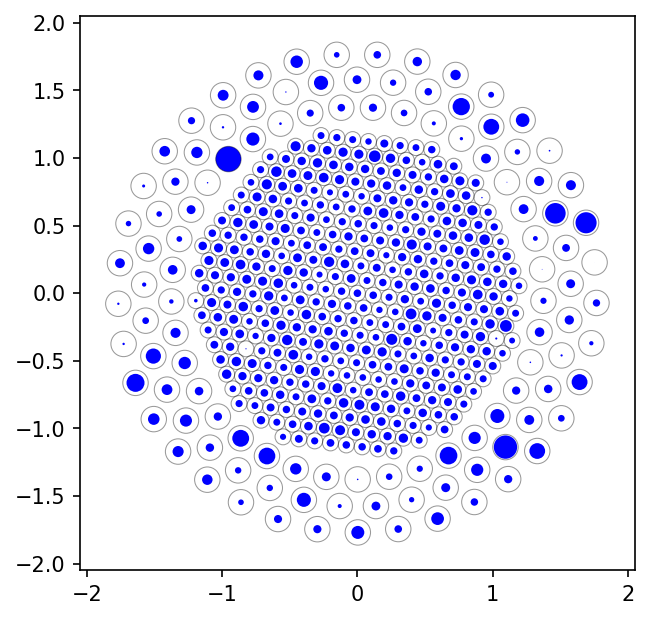

In [5]:
plot_camera(ped_rms[:490]);
# matplotlib.pyplot.axis('square')

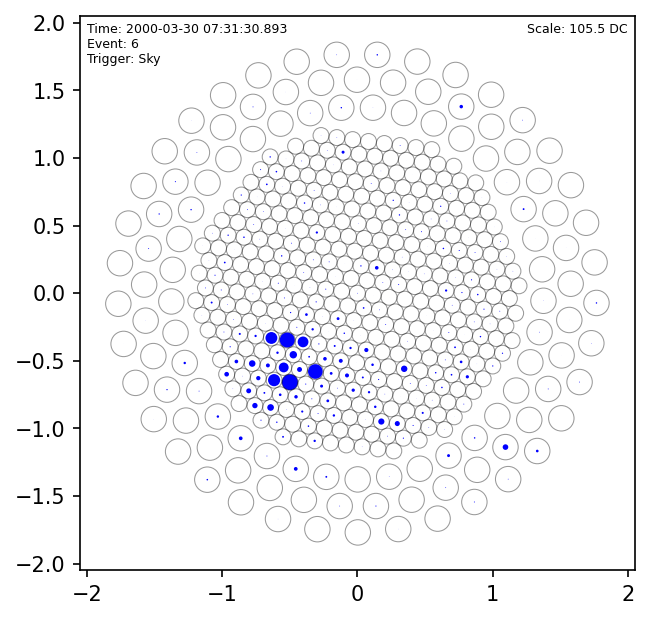

In [6]:
with fzreader.FZReader('gt014862.fz',verbose=False) as fz:
    fig, ax = matplotlib.pyplot.subplots(dpi=150)
    try:
        for record in fz:
            if(record['record_type'] == 'event'):
                adc_values = numpy.asarray(record['adc_values'], dtype=float)
                ax.clear()
                signal = (adc_values-ped_val)[:490]
                ax = plot_camera(signal, ax=ax)
                ax.text(-2.0,2.0,f"Time: {record['record_time_str']}\nEvent: {record['event_num']}\nTrigger: {record['event_type'].capitalize()}",
                        fontsize=6,ha='left',va='top')
                ax.text(2.0,2.0,f"Scale: {max(signal):.1f} DC",fontsize=6,ha='right',va='top')
                IPython.display.clear_output(wait=True)
                IPython.display.display(fig)
                fig.canvas.draw()
                matplotlib.pyplot.pause(0.05)
    except KeyboardInterrupt:
        matplotlib.pyplot.show()